# TODO fase 1
 - calculate predictions for a stock fx apple
 - statistics for the predictions: distribution of errors, percentage prediction with the right direction:  close>open, open<close
 - visualize ohlc as bands and on stock curve
 - split in train, test so that test data are taken from time periodens after the training data and possibly from stocks that have not been used for training 

 - tjek quantile objective function
 - objectiv function that weigh open and closing prices higher

 - add day of week to training data
 - speed up training: improve the pandas part by 60 times
                                                                                                                                   
# TODO fase 2
 - language modelling

In [ ]:
#default_exp finance.data

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from lib.data.lists import *
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [ ]:
# Version of the SimFin Python API.
sf.__version__

'0.8.1'

# Define location of Simfin data and license

In [ ]:
# export
def initiateSimFin(key='free'):
    # SimFin data-directory.
    sf.set_data_dir('~/simfin_data/')
    # SimFin load API key or use free data.
    sf.load_api_key(path='~/simfin_api_key.txt', default_key=key)
    return Path.home()/"simfin_data"

In [ ]:
%%time
#Load shareprices for testing and development

dataPath = initiateSimFin(key='free')
print(f"dataPath:{dataPath} exists:{dataPath.exists()}")

# Data for USA.
market = 'us'
# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market)
df_prices.head()

dataPath:/Users/kasparlund/simfin_data exists:True
Dataset "us-shareprices-daily" on disk (6 days old).
- Loading from disk ... Done!
CPU times: user 26.1 s, sys: 1.4 s, total: 27.5 s
Wall time: 27.5 s


SimFinId   Open    Low   High  Close  Adj. Close  Dividend  \
Ticker Date                                                                     
A      2007-01-03     45846  34.99  34.05  35.48  34.30       22.69       NaN   
       2007-01-04     45846  34.30  33.46  34.60  34.41       22.76       NaN   
       2007-01-05     45846  34.30  34.00  34.40  34.09       22.55       NaN   
       2007-01-08     45846  33.98  33.68  34.08  33.97       22.47       NaN   
       2007-01-09     45846  34.08  33.63  34.32  34.01       22.50       NaN   

                    Volume  Shares Outstanding  
Ticker Date                                     
A      2007-01-03  2574600                 NaN  
       2007-01-04  2073700                 NaN  
       2007-01-05  2676600                 NaN  
       2007-01-08  1557200                 NaN  
       2007-01-09  1386200                 NaN

# Prepare data for prediction of next days stock prices the next day
Create OHLC price changes as percentages relative to the close of the previous day. Furthermore the ohlc is supplemented by the previous days closing.

In [ ]:
# export

PREV_CLOSE = "previous_close"
def alignPrices(df_prices):
    # Make a new column to show the closing price from the previous day on the same line as current day. 
    # This is done using the shift function for the dataserie
    # 
    # Result: All stock and prices are listed in the same tabel. Therefore, the firat priceline of each stock vil now 
    # contain the close of the previous stock. For the first stock this value vil be "nan". 
    # These incoherent pricelines are removed in the nest step
    
    #if PREV_CLOSE not in df_prices.columns: 
    if not PREV_CLOSE in df_prices.columns: 
        df_prices.insert(df_prices.columns.get_loc(OPEN), PREV_CLOSE, df_prices[CLOSE].shift(), allow_duplicates=False)

    #identify the first stock in each stockgroup and the remove it
    stock_name    = df_prices.index.get_level_values(0)
    new_stock     = np.ones(len(df_prices), dtype=bool)
    new_stock[1:] = stock_name[0:len(stock_name)-1] != stock_name[1:len(stock_name)]
    df_prices.drop(df_prices.index[new_stock], axis=0, inplace=True)
    return df_prices

#Convert OHLC to percentages of the previous days closing price
def convertToPercentages(df_prices):
    df_prices[[OPEN,CLOSE,LOW,HIGH]] = df_prices[[OPEN,CLOSE,LOW,HIGH]].sub(df_prices[PREV_CLOSE],axis=0)\
                                        .div(df_prices[PREV_CLOSE],axis=0)
    return df_prices

In [ ]:
# export

#   extrem_increase,extrem__decrease = [], 2.5, -.73
#   extrem_increase,extrem__decrease = [], 1.5, -.5
EXTREM_HL = "extrem_hl"
def flagstocks_extrem_hl(df_prices, extrem_increase, extrem__decrease):
    #remove mature stocks with "nan" prices
    if EXTREM_HL in df_prices.columns: 
        df_prices.drop(labels=EXTREM_HL,axis=1,inplace=True)
                       
    gt_p = df_prices[[HIGH]].gt(extrem_increase)
    gt_p.insert(0,"lt",df_prices[[LOW]].lt(extrem__decrease))
    df_prices.insert(df_prices.columns.get_loc(SIMFIN_ID)+1,EXTREM_HL,gt_p.any(axis=1))    
    return df_prices

TOO_FEW_DAYS = "too_few_days"
def flagstocks_too_few_trading_days(df_prices, minimum_days):
    grp_res = df_prices.groupby(["Ticker"]).apply(lambda group: len(group) < minimum_tradingdays) 
    grp_res.name = TOO_FEW_DAYS
    merged = df_prices[[SIMFIN_ID]].join(grp_res, on=TICKER)
    if TOO_FEW_DAYS in df_prices.columns: 
        df_prices.drop(labels=TOO_FEW_DAYS,axis=1,inplace=True)
    df_prices.insert(df_prices.columns.get_loc(SIMFIN_ID)+1, TOO_FEW_DAYS, merged[TOO_FEW_DAYS].values)
    return df_prices

HAS_NAN_DAYS = "has_nan_days"
def flagstocks_with_nan_days(df_prices):
    grp_res = df_prices.groupby(["Ticker"]).apply(lambda group: group[[OPEN,LOW,HIGH,CLOSE]].isnull().values.any() ) 
    grp_res.name = HAS_NAN_DAYS
    merged = df_prices[[SIMFIN_ID]].join(grp_res, on=TICKER)
    if HAS_NAN_DAYS in df_prices.columns: 
        df_prices.drop(labels=HAS_NAN_DAYS,axis=1,inplace=True)
    df_prices.insert(df_prices.columns.get_loc(SIMFIN_ID)+1, HAS_NAN_DAYS, merged[HAS_NAN_DAYS].values)
    return df_prices

def findInValidStocks(df_prices):
    flags  = [HAS_NAN_DAYS,TOO_FEW_DAYS,EXTREM_HL]
    groups = df_prices.groupby(["Ticker"])
    return np.array([name for (name,group) in groups if group[flags].any(axis=1).any()])

def findValidStocks(df_prices):
    flags  = [HAS_NAN_DAYS,TOO_FEW_DAYS,EXTREM_HL]
    groups = df_prices.groupby(["Ticker"])
    return np.array([name for (name,group) in groups if not group[flags].any(axis=1).any()])


# find valid and invalid stocks
#df_prices[df_prices[[HAS_NAN_DAYS,TOO_FEW_DAYS,EXTREM_HL]].any(axis=1)]
len(findValidStocks(df_prices)), len(findInValidStocks(df_prices))

# Create dataset
The dataset must a batch with number of stock = batch_size  
Each sequence of stockprice (ohlc) return from the dataset must be of the samme sequence_length
During the training the network will process the sequence day by day

At the beginning of each epoch
    It must be possible to shuffle the stock 
    It must be possible to shuffle the start date of the stockprices for each stock 

The dataframe will remain fixed during the training using indirect indexing 
This will be faster and use less memory for large dataframes.


In [ ]:
# export
import torch
from lib.data.lists import *
torch.set_default_dtype(torch.float64)

#Create a dataset that uses all the stocks and daily prices during one epoch
#an epoch starts by choosing a new set of stocks at random.

#stocks    : are the stock tickers
#stock_days: is the number of days pr stock. The number of days is in different for each stock
#            The total number of samples is stock_days.sum()
#batch_size: is the number of stocks in a batch
#seq_length: is the number of stocks days in a batch

#The length of the dataset is: stock_days.sum() / (batch_size*sequence_length) rounded to the nearest integer.

#When the offset+seq_length+1 exceeds the number of days in the stock then the sequences is
#restarted at 0 or a random offset 

#As for now the dataset progress sequentially through the data during an epoch from a random offset. 
#Notice that there is no end of sequence-token to reset the model when the sequencen wraps around

class OHLCDataset(torch.utils.data.Dataset):
    #x, y significes input vs output
    def __init__(self, df_prices, stocks, seq_length): 
        self.df_prices   = df_prices
        self.stock_grps  = self.df_prices.groupby(["Ticker"])
        self.stocks      = np.array(list(self.stock_grps.groups)) if stocks is None else stocks
        self.seq_length  = seq_length
        self.column_names= [OPEN,HIGH,LOW,CLOSE]
        self.ix_columns  = [self.df_prices.columns.get_loc(k) for k in self.column_names]

        #Index to all start of sequences in the dataset
        #The target is taken from the day after the sequence
        self.idx_seq      = None
        self.price_values = None

    def __len__(self): 
        if self.idx_seq is None: self.initializeSquenzing()
        return len(self.idx_seq)

    def __getitem__(self, index):
        #pt: price target
        #pi: price input
        ix = self.idx_seq[index,:]
        pi = torch.tensor(self.price_values[ix[0]:ix[1]])
        pt = torch.tensor(self.price_values[ix[1]])
        return pi, pt #, index
    """
    def __getitem__(self, index):
        #pt: price target
        #pi: price input
        ix = self.idx_seq[index,0]
        pi = torch.tensor(self.price_values[self.idx_seq[index,0]:self.idx_seq[index,1]])
        pt = torch.tensor(self.price_values[self.idx_seq[index,1]])
        return pi, pt #, index
        
    def __getitem__(self, index):
        #pt: price target
        #pi: price input
        (ib,ie) = self.idx_seq[index,:]
        pi = torch.tensor(self.price_values[ib:ie])
        pt = torch.tensor(self.price_values[ie])
        return pi, pt #, index
    def __getitem__(self, index):
        #pt: price target
        #pi: price input
        ib = self.idx_seq[index]
        ie = ib+self.seq_length
        pi = torch.tensor(self.price_values[ib:ie])
        pt = torch.tensor(self.price_values[ie])
        return pi, pt #, index
    """
    #stocks: stocks that you want the price_input and target for    
    def getBatch(self, stocks):
        #pt: price target
        #pi: price input
        #extract the rows in df_proces containing the stocks in the batch
        pt = self.df_prices[ self.df_prices.index.get_level_values(0).isin(stocks) ]
        pi = [self.df_prices.iloc[ib:ie, self.ix_columns].values for ib,ie in zip(pt.idx, pt.idx+self.seq_length)]
        return np.array(pi), pt

    def initializeSquenzing(self):
        #Notice that the dataset cannot be used for a RNN where the data should been returned from a sliding window

        #Calculate the start and end of all sequences so that the dataloader can load and shuffle efficiently.  
        #add an index column to df_prices that we can used to calcualte start and end of sequences
        if not "idx" in self.df_prices.columns:
            self.df_prices.insert(loc=0, column="idx", value=np.arange(len(df_prices),dtype=int))
        
        #get an index to all valid samples
        idx_begin = [] #list of valid dataset index into the dataframe        
        for stock in self.stocks:
            group = self.stock_grps.get_group(stock)
            idx_begin.extend( group["idx"].values[:len(group)-seq_length] )
            
        self.idx_seq = np.empty( (len(idx_begin),2), dtype=int)  
        self.idx_seq[:,0] = idx_begin
        self.idx_seq[:,1] = self.idx_seq[:,0]+1

        #self.idx_seq      = np.empyt((len(idx_begin),2), dtype=int)  
        #self.idx_seq[:,0] = idx_begin, dtype=int
        self.price_values = self.df_prices[self.column_names].values
        
    def dataloader(self, batch_size:int, shuffle:bool, num_workers:int=0, drop_last=False):
        self.initializeSquenzing()
        return torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=shuffle,
                                           num_workers=num_workers, drop_last=drop_last)
    
    def split2train_test(self, test_percentage):
        #split the stocks in train and test stocks
        #It might be better to make a split in historical vs new prices 
        ix_all   = np.arange(len(self.stocks),dtype=int)
        np.random.shuffle(ix_all)
        
        nb_test  = int(round(test_percentage*len(self.stocks)))
        ix_train = ix_all[nb_test:]
        ix_test  = ix_all[:nb_test]
        return OHLCDataset(self.df_prices, self.stocks[ix_train], self.seq_length),\
               OHLCDataset(self.df_prices, self.stocks[ix_test],  self.seq_length)

# Test

In [ ]:
%%time
# load and identify valid data
%time alignPrices(df_prices)
%time convertToPercentages(df_prices)

seq_length          = 60  #dage
minimum_tradingdays = 180 #10*seq_length+1 #dage 
#extrem_increase,extrem__decrease = 2.5, -.73
extrem_increase,extrem__decrease = 1.5, -.5
%time flagstocks_extrem_hl(df_prices, extrem_increase, extrem__decrease)
%time flagstocks_too_few_trading_days(df_prices,minimum_tradingdays)
%time flagstocks_with_nan_days(df_prices)

%time validStocks, inValidStocks = findValidStocks(df_prices), findInValidStocks(df_prices)

stock_grps = df_prices.groupby(["Ticker"])
stocks     = np.array(list(stock_grps.groups))
sizes      = stock_grps.size()
#print(f"number of stocks:         {len(stocks)}")
print(f"number of valid stocks:   {len(validStocks)}")
print(f"number of invalid stocks: {len(inValidStocks)}")
#print(f"number of extrem stocks:   {len(extrem_stocks)}")

print(f"smallest pricelines pr stock: {sizes.sort_values()[:10]}")
print(f"longest pricelines pr stock:  {sizes.sort_values()[-10:]}")


#len(df_prices), len(df_prices.loc[stocks[bdx_mature_stocks]]), \
#len(df_prices.loc[stocks[bdx_mature_stocks]])/len(df_prices)*100

CPU times: user 43.4 s, sys: 1.18 s, total: 44.6 s
Wall time: 44.7 s
CPU times: user 311 ms, sys: 205 ms, total: 516 ms
Wall time: 518 ms
CPU times: user 53.2 ms, sys: 17 ms, total: 70.2 ms
Wall time: 69.9 ms
CPU times: user 1.59 s, sys: 385 ms, total: 1.97 s
Wall time: 1.98 s
CPU times: user 3.17 s, sys: 463 ms, total: 3.63 s
Wall time: 3.64 s
CPU times: user 5.04 s, sys: 347 ms, total: 5.39 s
Wall time: 5.4 s
number of valid stocks:   2033
number of invalid stocks: 582
smallest pricelines pr stock: Ticker
NLN       1
WMG       2
SSI      17
GAMZ     18
PCP      24
BRCM     25
CYRP     26
GEPC     29
FTRCQ    30
MENI     38
dtype: int64
longest pricelines pr stock:  Ticker
HURC    3379
HUN     3379
HUM     3379
HTZ     3379
HTLD    3379
HTH     3379
HT      3379
HSY     3379
HST     3379
KBR     3379
dtype: int64
CPU times: user 54 s, sys: 2.63 s, total: 56.6 s
Wall time: 56.8 s


In [ ]:
%%time 
from lib.learner.learner import*
from lib.learner.optimizers import*
from lib.model.model import*
from lib.model.modelmanager import*
import torch.nn as nn

#each priceline has 4 datapoint:[OPEN,LOW,HIGH,CLOSE]
#batchsize is the number of stocks processed in parallel

#ohlc: almost all day to day variation are in the the range -1 to 1.
#For now we do not normalize the input. However we will have to do it sooner or later

#seq_length=45
ohlc_ds = OHLCDataset(df_prices, stocks=validStocks, seq_length=seq_length)
ohlc_ds.initializeSquenzing()

train_ds, test_ds = ohlc_ds.split2train_test(0.25)
print(f"number of stocks, train stocks, test stocks: {len(ohlc_ds.stocks)}, {len(train_ds.stocks)}, {len(test_ds.stocks)}")

databunch = DataBunch(train_ds.dataloader(batch_size=2048*4, shuffle=True,  drop_last=True), \
                      test_ds.dataloader( batch_size=4096*2, shuffle=False, drop_last=False), \
                      c_in=4, c_out=4)

#batch = next(iter(databunch.train_dl))
#view = view_tfm(4,seq_length)
#batch[0].dtype, batch[0].shape, view(batch[0]).shape

number of stocks, train stocks, test stocks: 2033, 1525, 508
CPU times: user 3.86 s, sys: 610 ms, total: 4.47 s
Wall time: 4.49 s


In [ ]:
len(ohlc_ds.idx_seq), len(ohlc_ds), len(ohlc_ds.price_values), len(df_prices)

(5330834, 5330834, 6843406, 6843406)

In [ ]:
%%time
l = [len(b[0]) for b in databunch.train_dl]

CPU times: user 1min 11s, sys: 1.27 s, total: 1min 12s
Wall time: 1min 11s


# Statics on the mature stocks
 - min, max, mean, std, percentiles
 - calculate the normalization numbers


In [ ]:
print("the following must be the same")
%time stock_days = [len(ohlc_ds.stock_grps.get_group(stock)) for stock in ohlc_ds.stocks]
len(ohlc_ds), sum(stock_days)-len(stock_days)*(seq_length+1)

the following must be the same
CPU times: user 681 ms, sys: 9.07 ms, total: 690 ms
Wall time: 690 ms


(5330834, 5328801)

In [ ]:
#statistics
df_prices.loc[ohlc_ds.stocks,[PREV_CLOSE,OPEN,HIGH,LOW,CLOSE]].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])

,previous_close,Open,High,Low,Close
count,5.452814e+06,5.452814e+06,5.452814e+06,5.452814e+06,5.452814e+06
mean,1.645078e+02,2.178618e-04,1.649711e-02,-1.613212e-02,5.501282e-04
std,4.979344e+03,1.652678e-02,2.697750e-02,2.462773e-02,2.928071e-02
min,2.000000e-02,-5.000000e-01,-4.800989e-01,-5.000000e-01,-5.000000e-01
0.02%,6.000000e-02,-2.137199e-01,-1.561031e-01,-3.292862e-01,-2.703173e-01
25%,1.520000e+01,-3.935865e-03,3.807107e-03,-2.225379e-02,-1.051304e-02
50%,2.957000e+01,0.000000e+00,1.079417e-02,-1.064184e-02,0.000000e+00
75%,5.393000e+01,4.559025e-03,2.192243e-02,-3.395201e-03,1.118881e-02
99.98%,2.162699e+05,2.282198e-01,4.400000e-01,1.520392e-01,3.332735e-01
max,3.449700e+05,1.407407e+00,1.477419e+00,1.210095e+00,1.421652e+00


In [ ]:
%%time
# setup model
from lib.model.model import *

from functools import partial
#layers_sizes = [64,64,128,256]
#layers_sizes = [128,64,32]
layers_sizes = [64]
layer = partial( conv_layer1, stride=1, bn=False, zero_bn=False, act=GeneralRelu, dropout_ratio=0.15 )
mm    = CnnModelManager( get_cnn_model1(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)

tensor_input_view = view_tfm(4,seq_length)

xb,_ = mm.getFirstbatch( databunch, normalization = tensor_input_view)
print(f"input shape:{xb.shape}")
mm.summary(xb, print_mod=False)

get_cnn_layers
channels pr layers from input to output: [4, 64, 4]
number of input and hidden layers: 1
number of output layers :          3
total number of layers:            4
exception: {e}
exception received 3
:Traceback (most recent call last):
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 153, in one_batch
    self.msn.notify(Stages.begin_batch,event)
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 68, in notify
    f(event)
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 192, in begin_batch
    def begin_batch(self, e:Event): e.learn.xb = self.tfm(e.learn.xb)
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 459, in _inner
    def _inner(x): return x.view(*((-1,)+size))
RuntimeError: shape '[-1, 4, 60]' is invalid for input of size 32768



AttributeError: 'GetOneBatchCallback' object has no attribute 'xb'

# We start by a regressionmodel that predict the next OHLC
 - First try will be the to minimize the squared sum of errors.

In [ ]:
#def my_mse_loss(t_in, t_target): return (t_in-t_target).square().mean()

sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(CudaCallback, device= torch.device('cuda',0)),
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = tensor_input_view), 
#                partial(MixUp,α=0.4),
#                LR_Finder,                
                Recorder, 
#                partial(AvgStatsCallback,[accuracy]),
#                partial(AvgStatsCallback,[my_mse_loss]),
                partial(AvgStatsCallback,[torch.nn.functional.mse_loss]),
#                partial(AvgStatsCallback,[torch.nn.functional.smooth_l1_loss]),
                ProgressCallback
               ]

In [ ]:
opt       = SGD(sched,max_lr=0.25)
loss_func = torch.nn.MSELoss()
#loss_func = torch.nn.SmoothL1Loss()
#loss_func = my_mse_loss 

learn = Learner( mm.model, databunch, loss_func=loss_func)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

exception: {e}
exception received 3
:Traceback (most recent call last):
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 153, in one_batch
    self.msn.notify(Stages.begin_batch,event)
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 68, in notify
    f(event)
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 192, in begin_batch
    def begin_batch(self, e:Event): e.learn.xb = self.tfm(e.learn.xb)
  File "/Users/kasparlund/code/AICodeData/ai/lib/learner/learner.py", line 459, in _inner
    def _inner(x): return x.view(*((-1,)+size))
RuntimeError: shape '[-1, 4, 60]' is invalid for input of size 32768

CPU times: user 1.45 s, sys: 59 ms, total: 1.51 s
Wall time: 931 ms


AttributeError: 'NoneType' object has no attribute 'items'

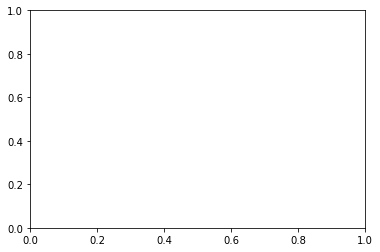

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(skip_start=0),plt.show()

In [ ]:
%%time
#def predict(learn, price_sequences, tfm):
#    with torch.no_grad():
#        return learn.model( tfm(torch.tensor(price_sequences) ) )
price_sequences, price_targets = ohlc_ds.getBatch(stocks=["ABMD", "AAPL"])
predictions    = mm.predict(price_sequences, tensor_input_view)

(PREDICT_OPEN,PREDICT_HIGH,PREDICT_LOW,PREDICT_CLOSE) = ["predict_"+ name for name in [OPEN,HIGH,LOW,CLOSE]]
for idx,name in enumerate([PREDICT_OPEN, PREDICT_HIGH, PREDICT_LOW, PREDICT_CLOSE]):
    price_targets.insert(len(price_targets.columns), name, predictions[:,idx].numpy())
price_targets[[OPEN,HIGH,LOW,CLOSE,PREDICT_OPEN,PREDICT_HIGH,PREDICT_LOW,PREDICT_CLOSE]]

In [ ]:
from math import sqrt
sqrt(0.000587), 0.01**2


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()